In [2]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

In [3]:
class PreisachMemoryLayer(tf.keras.layers.Layer):
    def __init__(self, n_operators, **kwargs):
        super(PreisachMemoryLayer, self).__init__(name="PreisachMemoryLayer", **kwargs)
        self.n_operators = n_operators
        self.first_batch = True
    
    def build(self, input_shape):
        # TODO: check dimensionality of the tensors, most probably they are wrong
        # Change the last dimension of input_shape to be n_operators
        self.input_dim = input_shape
        self.play_operators = tf.Variable(initial_value=tf.zeros((input_shape[0], input_shape[1], self.n_operators)), trainable=False) # tf.zeros((input_shape)) # Fix the Data Structure
        self.prev_play_operators = tf.Variable(initial_value=tf.zeros((input_shape[0], self.n_operators)), trainable=False) # tf.zeros((input_shape)) # Fix the Data Structure
        self.r = np.zeros(self.n_operators)
        
        for j in range(self.n_operators):
            # Since the input signal is normalized between -1 and 1, these are also min and max
            self.r[j] = (j / self.n_operators) * (1 - (-1))
        
    def call(self, inputs):
        # TODO: Check dimensions of all the data structure, verify if the code is fine for stateful = False
        # TODO: Extend the code to work with stateful = True, using the Play Operators of the previous batch
        # TODO: Check if it is possible to remove the external loop over the batches
        for b in range(self.input_dim[0]):
            for t in range(self.input_dim[1]):
                for j in range(self.n_operators):
                    if t == 0:
                        if self.first_batch:
                            # TODO: FIX the dimensions for the array assignments?
                            self.play_operators[b, t, j].assign(tf.math.maximum(inputs[b, t, 0] - self.r[j], tf.math.minimum(inputs[b, t, 0] + self.r[j], 0))) # <-- The zero must be a Tensor with proper dimensions!
                        else:
                            self.play_operators[b, t, j].assign(tf.math.maximum(inputs[b, t, 0] - self.r[j], tf.math.minimum(inputs[b, t, 0] + self.r[j], self.prev_play_operators[b, j])))
                    else:
                        self.play_operators[b, t, j].assign(tf.math.maximum(inputs[b, t, 0] - self.r[j], tf.math.minimum(inputs[b, t, 0] + self.r[j], self.play_operators[b, t - 1, j])))
                
        if self.first_batch:
            self.first_batch = False
        
        self.prev_play_operators.assign(self.play_operators[:, t, :])
        
        # The following comment is used as a reference for the Play Operators definition
        # P_j(t) = max(u(t) - r_j, min(u(t) + r_j, P_j(t - 1)))
        # P_j(0) = max(u(0) - r_j, min(u(0) + r_j, k0))
        # r_j = (j - 1)/n * (max(u(t)) - min(u(t)))  j = 1, ..., n
        
        return self.play_operators

In [4]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
batch_size = 10

# To have cross-batch statefulness set stateful = True
stateful = True

Model: "PreisachRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(10, 20, 2)]        0           []                               
                                                                                                  
 PreisachMemoryLayer (PreisachM  (10, 20, 5)         1050        ['input_1[0][0]']                
 emoryLayer)                                                                                      
                                                                                                  
 concatenate (Concatenate)      (10, 20, 7)          0           ['input_1[0][0]',                
                                                                  'PreisachMemoryLayer[0][0]']    
                                                                                        

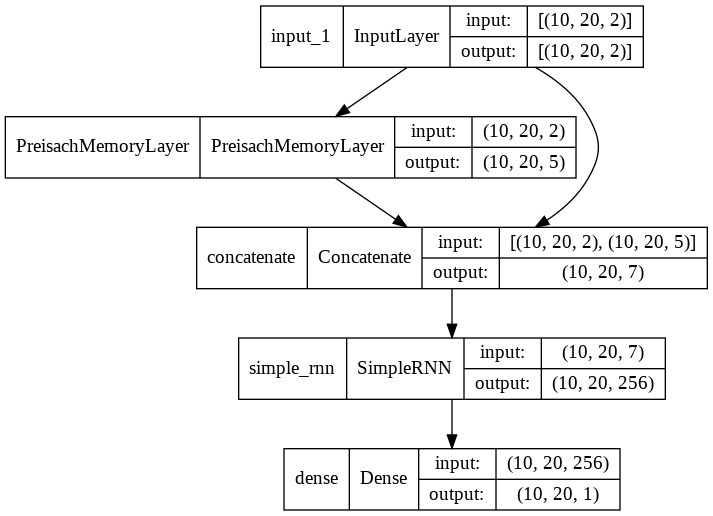

In [5]:
# Example: building a PreisachRNN using the custom Layer to implement Preisach Memory 

# Setting the number of Play Operators to be used by the model
n_operators = 5
rnn_units = 256

inputs = tf.keras.layers.Input(shape=(seq_len, 2,), batch_size=batch_size)
preisach_layer = PreisachMemoryLayer(n_operators=n_operators)(inputs)

concatenate = tf.keras.layers.concatenate([inputs, preisach_layer])

recurrent_layer = tf.keras.layers.SimpleRNN(units=rnn_units, return_sequences=True, stateful=stateful)(concatenate)
outputs = tf.keras.layers.Dense(1, activation='linear')(recurrent_layer)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='PreisachRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)